In [2]:
'''
keypointRCNN을 활용하여 어깨, 코 좌표 검출하기
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from PIL import Image
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T
import math
import glob

In [3]:
def find_shoulder(path) : 
    
    height_distance = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).to(device).eval()
    
    trf = T.Compose([
        T.ToTensor()
    ])
    
    imgs = [] # 경로가 path인 폴더 안에 들어있는 이미지 주소를 담을 리스트
    images = glob.glob(path)
    
    for fname in images :
        imgs.append(fname)
    
    for fname in imgs:
        img = Image.open(fname) # 리스트 안에 들어있는 경로로 이미지 호출
        img = img.resize((224,224)) # 크기 변경
        input_img = trf(img).to(device) # CPU to GPU
        out = model([input_img])[0]
        THRESHOLD = 0.9 # 해당 정보의 정확도가 90% 이상인 것만 사용
        
        # 이미지 그리기
        fig , axes = plt.subplots()
        axes.imshow(img)

        # 랜드마크(어깨, 코) 찾기
        # 이미지의 keys에 들어있는 것 : boxes, labels, scores, keypoints, keypoints_scores
        # boxes : 사람의 형태를 인지 -> 박스의 왼쪽 상단, 오른쪽 하단의 좌표를 인식
        # scores : 사람일 확률. 0.98 0.97 이런 확률 값이 들어있음

        for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
            # score, box, keypoints마다 텐서값을 떼어내고 numpy 형태로 전환
            score = score.detach().cpu().numpy() # GPU to CPU
            if score < THRESHOLD:
                continue
            box = box.detach().cpu().numpy() # GPU to CPU

            '''
            keypoints에는 [n,k,x] 형태의 텐서가 들어있음.
            n : 사람일 가능성이 있는 bounding box의 갯수
            k : 키포인트의 갯수
            x : visibility.
                0 몸이나 사물에 가려서 안보이는 경우
                1 : 보이는 경우
            '''
            # keypoints에서 visibility는 제외한다.

            keypoints = keypoints.detach().cpu().numpy()[:, :2] # GPU to CPU g

            # 좌표 찾기
            for i, k in enumerate(keypoints):
                if i == 5 : # 왼쪽 어깨
                    left_shoulder = k
                elif i == 6 : # 오른쪽 어깨
                    right_shoulder = k
                elif i == 0 : # 코
                    nose = k
                    
            # 포인트 그리기
            left_shoulder_point = patches.Circle((left_shoulder[0],left_shoulder[1]), radius = 5, facecolor = 'pink')
            right_shoulder_point = patches.Circle((right_shoulder[0],right_shoulder[1]), radius = 5, facecolor = 'red')
            nose_point = patches.Circle((nose[0],nose[1]), radius = 5, facecolor = 'blue')
            
            # print(left_shoulder, right_shoulder)
            distance = abs(left_shoulder[1] - right_shoulder[1])

            axes.axis('off')
            axes.add_patch(left_shoulder_point)
            axes.add_patch(right_shoulder_point)
            axes.add_patch(nose_point)
            axes.set_title('height distance : ' + str(distance))
            
                # 어깨 높이 차이(distance)를 구하고 shoulder_distance에 추가
            distance = abs(left_shoulder[1] - right_shoulder[1])
            height_distance[distance] = fname # 딕셔너리에 추가

        plt.show()

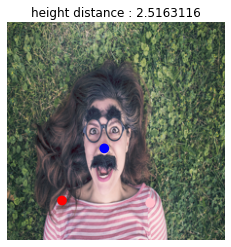

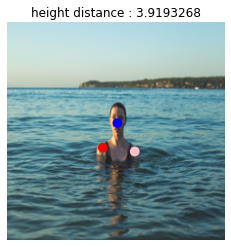

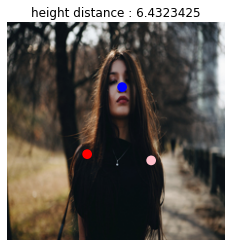

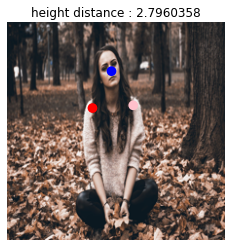

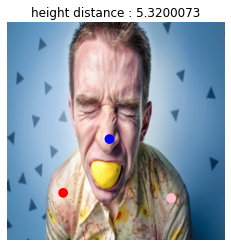

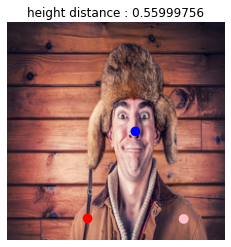

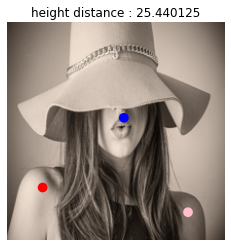

None


In [5]:
hd = find_shoulder('./shoulder_test_image/*.jpg')
print(hd)